In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
plt.set_cmap('gray');
%matplotlib inline
import seaborn_image as isns
import seaborn as sns


### Import train data

In [2]:
data_path = Path().resolve().parent.absolute() /  'dataset' 

In [3]:
data_path.is_dir()

True

In [4]:
train_data = pd.read_csv(data_path / 'train.csv')
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
len_train_data = len(train_data)
len_train_data

42000

In [6]:
images = train_data.iloc[:, 1:].div(255).values.reshape(len_train_data, 1, 28, 28)

### Plot train data

In [7]:
def get_number(num):
    return np.flip(train_data[train_data['label'] == num].iloc[0,1:].values.reshape(28,28),0)

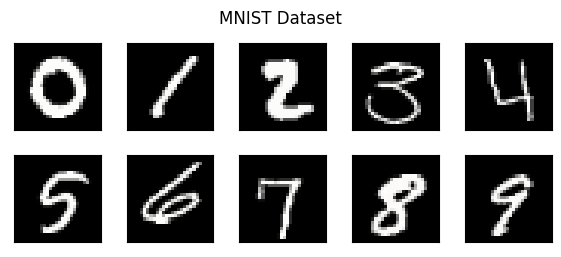

In [8]:
fig, axes = plt.subplots(2, 5,figsize=(5.5, 2.5),layout="constrained");

fig.suptitle('MNIST Dataset')
isns.imshow(ax=axes[0, 0], data=get_number(0),cmap='gray',cbar=False)
isns.imshow(ax=axes[0, 1], data=get_number(1),cmap='gray',cbar=False)
isns.imshow(ax=axes[0, 2], data=get_number(2),cmap='gray',cbar=False)
isns.imshow(ax=axes[0, 3], data=get_number(3),cmap='gray',cbar=False)
isns.imshow(ax=axes[0, 4], data=get_number(4),cmap='gray',cbar=False)
isns.imshow(ax=axes[1, 0], data=get_number(5),cmap='gray',cbar=False)
isns.imshow(ax=axes[1, 1], data=get_number(6),cmap='gray',cbar=False)
isns.imshow(ax=axes[1, 2], data=get_number(7),cmap='gray',cbar=False)
isns.imshow(ax=axes[1, 3], data=get_number(8),cmap='gray',cbar=False)
isns.imshow(ax=axes[1, 4], data=get_number(9),cmap='gray',cbar=False);

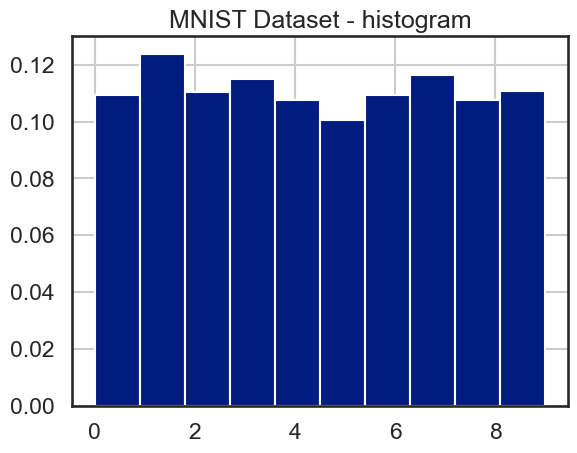

In [9]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

train_data['label'].hist(density=1,bins=10);
plt.title('MNIST Dataset - histogram');

### Custom Datasets in PyTorch

In [142]:
import torch
from torch.utils.data import Dataset, DataLoader

In [143]:
class TrainDataset(Dataset):

    def __init__(self, data_path):
        self.train_df = pd.read_csv(data_path)
        self.images = self.train_df.iloc[:, 1:].div(255).values.reshape(len(self.train_df), 1, 28, 28)
        self.img_label = self.train_df.iloc[:, 0].values

    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, idx):
        self.image = torch.tensor(self.images[idx], dtype=torch.float32)
        self.label = torch.tensor(self.img_label[idx])
        return self.image, self.label


class TestDataset(Dataset):

    def __init__(self, data_path):
        self.test_df = pd.read_csv(data_path)
        self.images = self.test_df.iloc[:, :].div(255).values.reshape(len(self.test_df), 1, 28, 28)

    def __len__(self):
        return len(self.test_df)

    def __getitem__(self, idx):
        self.image = torch.tensor(self.images[idx], dtype=torch.float32)
        return self.image


In [144]:
train_dataset = TrainDataset(data_path / 'train.csv')

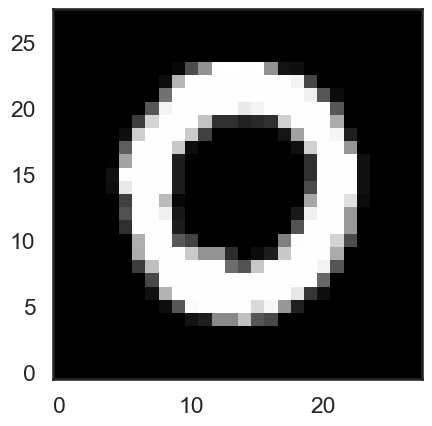

In [145]:
plt.imshow(train_dataset[1][0].numpy()[0], cmap='gray');

### Model

The model was built based on convolutional neural networks:
- CNN: in_channels 1 kernel 3x3, stride 1x1, padding 1x1, out_channles 16,
- Batch Normalization 16 channels,
- CNN: in_channels 16 kernel 3x3, stride 1x1, padding 1x1, out_channles 32,
- Batch Normalization 32 channels,
- Linear Fully Connected Layer.

In [150]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channel=1, num_classes=10):
        super().__init__()
        # input 28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.conv1_bn = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),  bias=False)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(25088, num_classes)
        self.fc1_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        flat = conv2.reshape(conv2.shape[0], -1)
        logits = self.fc1_bn(self.fc1(flat))
        return F.log_softmax(logits, dim=1)



### Train function

In [157]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(learning_rate=0.001, num_epochs=10,data_path =  Path().resolve().parent.absolute() /  'dataset' ):

    def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
        print("Save checkpoint")
        save_path = Path('checkpoint') / filename
        torch.save(state, save_path)

    def load_checkpoint(checkpoint):
        print("Loading checkpoint")
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])


    # Hyperparameters
    in_channel = 1
    num_classes = 10
    learning_rate = learning_rate
    batch_size = 32
    num_epochs = num_epochs


    # Load Dataset
    train_dataset = TrainDataset(data_path / 'train.csv')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize network
    model = CNN(in_channel=in_channel, num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    loss_vals = []
    for epoch in range(num_epochs):

        epoch_loss = []
        for batch_idx, (data, targets) in enumerate(train_loader):
            # CUDA
            data = data.to(device=device)
            targets = targets.to(device=device)

            optimizer.zero_grad()
            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            # backward
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        loss_vals.append(sum(epoch_loss) / len(epoch_loss))
    return model, device, train_loader, loss_vals

In [158]:
learning_rate = 0.001
num_epochs = 8
model, device, train_loader, losses = train(num_epochs=num_epochs, learning_rate=learning_rate)

### Check accuracy - train data

In [159]:
def check_accuracy_train(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f" {num_correct} / {num_samples} {(float(num_correct/num_samples))*100:.2f}")
    model.train()

In [160]:
check_accuracy_train(loader=train_loader, model=model)

 41977 / 42000 99.95


### Check accuracy - test data

In [161]:
def check_accuracy_test(test_loader, model, data_path):
    predictions = np.array([])
    model.eval()
    with torch.no_grad():
        for image in test_loader:
            scores = model(image)
            _, predicted = torch.max(scores, 1)
            predictions = np.append(predictions, predicted)
    model.train()
    return predictions

In [162]:
data_path = Path().resolve().parent.absolute() /  'dataset' 
test_dataset = TestDataset(data_path / 'test.csv')
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
predictions = check_accuracy_test(test_loader, model, data_path)

In [163]:
predictions

array([2., 0., 9., ..., 3., 9., 2.])